In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import logging
import matplotlib.pyplot as plt


In [3]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %I:%M:%S %p %Z'
)
logging.info("Optimized Full LSTM Script started at 12:50 PM IST on Thursday, June 12, 2025")

# Paths
metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
data_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"


2025-07-03 12:15:58 PM India Standard Time - INFO - Optimized Full LSTM Script started at 12:50 PM IST on Thursday, June 12, 2025


In [5]:
# Load metadata and ensure Re is numeric
try:
    metadata = pd.read_csv(metadata_path)
    if 'Re' not in metadata.columns:
        logging.error("Re column not found in metadata")
        raise ValueError("Re column missing in metadata")
    metadata['Re'] = pd.to_numeric(metadata['Re'], errors='coerce')
    logging.info("Metadata Re column dtype after conversion:")
    logging.info(metadata['Re'].dtype)
    logging.info("Unique Re values in metadata:")
    logging.info(metadata['Re'].unique())
except FileNotFoundError:
    logging.error(f"Metadata file not found at {metadata_path}")
    raise


2025-07-03 12:16:00 PM India Standard Time - INFO - Metadata Re column dtype after conversion:
2025-07-03 12:16:00 PM India Standard Time - INFO - float64
2025-07-03 12:16:00 PM India Standard Time - INFO - Unique Re values in metadata:
2025-07-03 12:16:00 PM India Standard Time - INFO - [       nan 0.05605783 0.05319186 ... 0.09778722 0.09867936 0.0968088 ]


In [7]:
# Filter for B0005 and add cycle_index
metadata_filtered = metadata[metadata['battery_id'] == 'B0005'].copy()
metadata_filtered['cycle_index'] = range(len(metadata_filtered))
logging.info(f"Added cycle_index to metadata_filtered. Shape: {metadata_filtered.shape}")

# Propagate Re values
def propagate_re_values(df, initial_re=0.073589):
    current_re = float(initial_re)
    re_values = []
    for idx, row in df.iterrows():
        if row['type'] == 'impedance':
            current_re = float(row['Re']) if not pd.isna(row['Re']) else current_re
        re_values.append(current_re)
    df['Re_propagated'] = re_values
    return df

metadata_filtered = propagate_re_values(metadata_filtered, initial_re=0.073589)
logging.info(f"Total rows after filtering: {len(metadata_filtered)}")
logging.info(f"Rows with valid propagated Re: {metadata_filtered['Re_propagated'].notna().sum()}")
logging.info(f"Rows with missing propagated Re: {metadata_filtered['Re_propagated'].isna().sum()}")

if metadata_filtered['Re_propagated'].isna().sum() > 0:
    logging.error("Some rows still have missing Re values after propagation.")
    raise ValueError("Propagation failed: Some rows still have missing Re values.")


2025-07-03 12:16:01 PM India Standard Time - INFO - Added cycle_index to metadata_filtered. Shape: (616, 11)
2025-07-03 12:16:01 PM India Standard Time - INFO - Total rows after filtering: 616
2025-07-03 12:16:01 PM India Standard Time - INFO - Rows with valid propagated Re: 616
2025-07-03 12:16:01 PM India Standard Time - INFO - Rows with missing propagated Re: 0


In [9]:
# Function to parse complex numbers and return magnitude
def parse_complex(value):
    try:
        if isinstance(value, complex):
            return abs(value)
        if isinstance(value, str):
            value = value.strip('()')
            if 'j' in value:
                if 'e' in value:
                    parts = value.split('j')
                    real_part = float(parts[0].split('-')[0]) if '-' in parts[0] else float(parts[0])
                    imag_part = parts[1].replace('j', '')
                    if imag_part:
                        if imag_part.startswith('-'):
                            imag_part = float(imag_part)
                        else:
                            imag_part = float(imag_part) if imag_part else 0.0
                    else:
                        imag_part = 0.0
                    return abs(complex(real_part, imag_part))
                else:
                    if '+' in value:
                        real, imag = value.split('+')
                    else:
                        parts = value.split('-')
                        real = parts[0] if parts[0] else '0'
                        imag = '-' + parts[1] if len(parts) > 1 else '0'
                        if len(parts) == 3:
                            real = '-' + parts[1]
                            imag = '-' + parts[2]
                    real = float(real) if real else 0.0
                    imag = float(imag.replace('j', '')) if imag else 0.0
                    return abs(complex(real, imag))
        return float(value)
    except (ValueError, TypeError) as e:
        logging.warning(f"Could not parse complex value {value}: {str(e)}")
        return np.nan


In [11]:
# Function to extract features for charge/discharge cycles
def extract_features_charge_discharge(filepath, re_value, cycle_type, cycle_index):
    try:
        df = pd.read_csv(filepath)
        required_columns = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time']
        if not all(col in df.columns for col in required_columns):
            logging.warning(f"Missing required columns in {filepath}: Found {df.columns.tolist()}")
            return None

        for col in required_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        if df[required_columns].isna().any().any():
            logging.warning(f"Non-numeric values found in {filepath} after conversion.")

        df['Power'] = df['Voltage_measured'] * df['Current_measured']
        energy = np.trapz(df['Power'], x=df['Time']) if not df['Power'].isna().any() and not df['Time'].isna().any() else np.nan
        duration = df['Time'].iloc[-1] - df['Time'].iloc[0] if not df['Time'].isna().any() else np.nan

        features = {
            'avg_current': df['Current_measured'].mean(),
            'min_current': df['Current_measured'].min(),
            'avg_voltage': df['Voltage_measured'].mean(),
            'max_voltage': df['Voltage_measured'].max(),
            'min_voltage': df['Voltage_measured'].min(),
            'std_voltage': df['Voltage_measured'].std(),
            'avg_temperature': df['Temperature_measured'].mean(),
            'max_temperature': df['Temperature_measured'].max(),
            'min_temperature': df['Temperature_measured'].min(),
            'temp_range': df['Temperature_measured'].max() - df['Temperature_measured'].min(),
            'voltage_range': df['Voltage_measured'].max() - df['Voltage_measured'].min(),
            'duration': duration,
            'energy': energy,
            'avg_impedance': np.nan,
            'Re': re_value,
            'cycle_index': cycle_index,
            'cycle_type': cycle_type
        }
        logging.info(f"Successfully extracted features from {filepath} (type: {cycle_type})")
        return features
    except Exception as e:
        logging.error(f"Error processing {filepath}: {str(e)}")
        return None


In [13]:
# Function to extract features for impedance cycles
def extract_features_impedance(filepath, re_value, cycle_type, cycle_index):
    try:
        df = pd.read_csv(filepath)
        required_columns = ['Battery_impedance']
        if not all(col in df.columns for col in required_columns):
            logging.warning(f"Missing required columns in {filepath}: Found {df.columns.tolist()}")
            return None

        df['Battery_impedance'] = df['Battery_impedance'].apply(parse_complex)
        avg_impedance = df['Battery_impedance'].mean() if 'Battery_impedance' in df.columns else np.nan

        features = {
            'avg_current': np.nan,
            'min_current': np.nan,
            'avg_voltage': np.nan,
            'max_voltage': np.nan,
            'min_voltage': np.nan,
            'std_voltage': np.nan,
            'avg_temperature': np.nan,
            'max_temperature': np.nan,
            'min_temperature': np.nan,
            'temp_range': np.nan,
            'voltage_range': np.nan,
            'duration': np.nan,
            'energy': np.nan,
            'avg_impedance': avg_impedance,
            'Re': re_value,
            'cycle_index': cycle_index,
            'cycle_type': cycle_type
        }
        logging.info(f"Successfully extracted features from {filepath} (type: {cycle_type})")
        return features
    except Exception as e:
        logging.error(f"Error processing {filepath}: {str(e)}")
        return None


In [15]:
# Extract features for each file
features_list = []
processed_files = []
skipped_files = []

for idx, row in metadata_filtered.iterrows():
    csv_name = row['filename']
    cycle_type = row['type']
    full_path = os.path.join(data_folder, csv_name)
    re_value = row['Re_propagated']
    cycle_index = row['cycle_index']

    if not os.path.exists(full_path):
        logging.warning(f"File not found: {full_path}")
        skipped_files.append(csv_name)
        continue

    if cycle_type in ['charge', 'discharge']:
        features = extract_features_charge_discharge(full_path, re_value, cycle_type, cycle_index)
    else:  # impedance
        features = extract_features_impedance(full_path, re_value, cycle_type, cycle_index)

    if features:
        features_list.append(features)
        processed_files.append(csv_name)
    else:
        skipped_files.append(csv_name)

logging.info(f"Processed {len(processed_files)} files: {processed_files}")
logging.info(f"Skipped {len(skipped_files)} files: {skipped_files}")


2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05121.csv (type: charge)
2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05122.csv (type: discharge)
2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05123.csv (type: charge)
2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05124.csv (type: discharge)
2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05125.csv (type: charge)
2025-07-03 12:16:53 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05126.csv (type: discharge)
2025-07-03 12:16:53 PM India Standard

In [17]:
# Create DataFrame
features_df = pd.DataFrame(features_list)
if features_df.empty:
    logging.error("No valid features extracted. Check logs for details.")
    raise ValueError("No valid features extracted.")

# Ensure Re and cycle_index columns are numeric
features_df['Re'] = pd.to_numeric(features_df['Re'], errors='coerce')
features_df['cycle_index'] = pd.to_numeric(features_df['cycle_index'], errors='coerce')
logging.info("features_df Re column dtype after conversion:")
logging.info(features_df['Re'].dtype)
logging.info("Unique Re values in features_df:")
logging.info(features_df['Re'].unique())

# Drop low-importance features
features_df = features_df.drop(columns=['duration', 'min_voltage', 'avg_current', 'temp_range', 'voltage_range'], errors='ignore')


2025-07-03 12:17:56 PM India Standard Time - INFO - features_df Re column dtype after conversion:
2025-07-03 12:17:56 PM India Standard Time - INFO - float64
2025-07-03 12:17:56 PM India Standard Time - INFO - Unique Re values in features_df:
2025-07-03 12:17:56 PM India Standard Time - INFO - [0.073589   0.0446687  0.046687   0.04484343 0.04619469 0.04510115
 0.04599074 0.04417208 0.04521711 0.04378663 0.04490995 0.04463932
 0.04717044 0.04355879 0.0464897  0.04526548 0.04636224 0.04448372
 0.04482791 0.04441416 0.04466451 0.04453545 0.04502135 0.04610647
 0.04646252 0.04766732 0.04772385 0.0478677  0.04694023 0.04561342
 0.04702798 0.04672887 0.04775538 0.04691623 0.04702294 0.04660479
 0.04624537 0.04683294 0.0461861  0.04624137 0.04773737 0.04942748
 0.04838334 0.04747842 0.04803751 0.04770362 0.04808696 0.04815105
 0.04754728 0.04759013 0.04764092 0.04764024 0.04842437 0.04893386
 0.04943075 0.04932301 0.04974823 0.04912203 0.04988487 0.04785945
 0.04921638 0.04887229 0.04994594 0

In [19]:
# Ensure avg_impedance exists
if 'avg_impedance' not in features_df.columns:
    features_df['avg_impedance'] = np.nan

# Add lagged Re features and Re differences
features_df['Re_lag1'] = features_df['Re'].shift(1).fillna(features_df['Re'].iloc[0])
features_df['Re_lag2'] = features_df['Re'].shift(2).fillna(features_df['Re'].iloc[1])
features_df['Re_diff'] = features_df['Re_lag1'] - features_df['Re_lag2']
logging.info("Added lagged Re features (Re_lag1, Re_lag2) and Re_diff")

# Encode cycle_type
features_df['cycle_type_encoded'] = features_df['cycle_type'].map({'charge': 0, 'discharge': 1, 'impedance': 2})
features_df = features_df.drop(columns=['cycle_type'])

# Convert all feature columns to numeric
numeric_cols = [col for col in features_df.columns if col not in ['Re']]
for col in numeric_cols:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# Handle missing values by forward filling
features_df[numeric_cols] = features_df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
logging.info("Columns with NaNs after filling:")
logging.info(features_df[numeric_cols].isna().sum())


2025-07-03 12:18:13 PM India Standard Time - INFO - Added lagged Re features (Re_lag1, Re_lag2) and Re_diff
C:\Users\AK\AppData\Local\Temp\ipykernel_2088\1025515347.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df[numeric_cols] = features_df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
2025-07-03 12:18:13 PM India Standard Time - INFO - Columns with NaNs after filling:
2025-07-03 12:18:13 PM India Standard Time - INFO - min_current           0
avg_voltage           0
max_voltage           0
std_voltage           0
avg_temperature       0
max_temperature       0
min_temperature       0
energy                0
avg_impedance         0
cycle_index           0
Re_lag1               0
Re_lag2               0
Re_diff               0
cycle_type_encoded    0
dtype: int64


In [21]:
# Remove outliers using IQR with a softer threshold
def remove_outliers(df, column, multiplier=6.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    dropped_rows = df[~df.index.isin(filtered_df.index)]
    if not dropped_rows.empty:
        logging.info(f"Dropped rows due to outliers in {column}:")
        logging.info(dropped_rows[['Re', column]])
    return filtered_df

numeric_cols_for_outliers = [col for col in numeric_cols if col != 'Re']
for col in numeric_cols_for_outliers:
    features_df = remove_outliers(features_df, col, multiplier=6.0)

logging.info(f"Features DataFrame shape after preprocessing: {features_df.shape}")

# Sort by cycle_index and reset index to avoid index mismatch
features_df = features_df.sort_values('cycle_index').reset_index(drop=True)

# Prepare features and target
X = features_df.drop(columns='Re')
y = features_df['Re']

# Scale features and target
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns, index=X.index)
logging.info("Features scaled using StandardScaler")

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
logging.info("Target (Re) scaled using StandardScaler")


2025-07-03 12:18:29 PM India Standard Time - INFO - Dropped rows due to outliers in max_voltage:
2025-07-03 12:18:29 PM India Standard Time - INFO -            Re  max_voltage
84   0.045021     8.393141
615  0.050036     4.985137
2025-07-03 12:18:29 PM India Standard Time - INFO - Dropped rows due to outliers in Re_diff:
2025-07-03 12:18:29 PM India Standard Time - INFO -            Re   Re_diff
41   0.044669 -0.028920
43   0.046687  0.002018
45   0.044843 -0.001844
47   0.046195  0.001351
49   0.045101 -0.001094
..        ...       ...
603  0.058989  0.000533
605  0.058801 -0.000188
607  0.057630 -0.001171
609  0.058984  0.001354
611  0.057824 -0.001160

[277 rows x 2 columns]
2025-07-03 12:18:29 PM India Standard Time - INFO - Dropped rows due to outliers in cycle_type_encoded:
2025-07-03 12:18:29 PM India Standard Time - INFO -            Re  cycle_type_encoded
0    0.073589                   0
1    0.073589                   1
2    0.073589                   0
3    0.073589        

In [23]:
# Function to create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X.iloc[i-seq_length:i].values)
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define sequence length
seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
logging.info(f"Created sequences with length {seq_length}. X_seq shape: {X_seq.shape}")


2025-07-03 12:18:41 PM India Standard Time - INFO - Created sequences with length 10. X_seq shape: (267, 10, 14)


In [25]:
# Chronological split (80% train, 20% test)
total_samples = len(X_seq)
train_size = int(0.8 * total_samples)
X_train = X_seq[:train_size]
X_test = X_seq[train_size:]
y_train = y_seq[:train_size]
y_test = y_seq[train_size:]
logging.info(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


2025-07-03 12:18:52 PM India Standard Time - INFO - Train set size: 213, Test set size: 54


In [27]:
# Build LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(seq_length, X_scaled.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')
logging.info("Optimized LSTM model compiled with learning rate 0.0005")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


C:\Users\AK\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-03 12:19:05 PM India Standard Time - INFO - Optimized LSTM model compiled with learning rate 0.0005


In [31]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)
logging.info("LSTM model training completed")

# Predict on test set
y_pred_scaled = model.predict(X_test, verbose=0)


2025-07-03 12:20:38 PM India Standard Time - INFO - LSTM model training completed


In [33]:
# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)

print(f"✅ Optimized LSTM Model Evaluation on Test Set:")
print(f"RMSE = {rmse:.5f}")
print(f"R²   = {r2:.5f}")
print(f"MAE  = {mae:.5f}")
print(f"MSE  = {mse:.5f}")


✅ Optimized LSTM Model Evaluation on Test Set:
RMSE = 0.00278
R²   = -0.23645
MAE  = 0.00212
MSE  = 0.00001


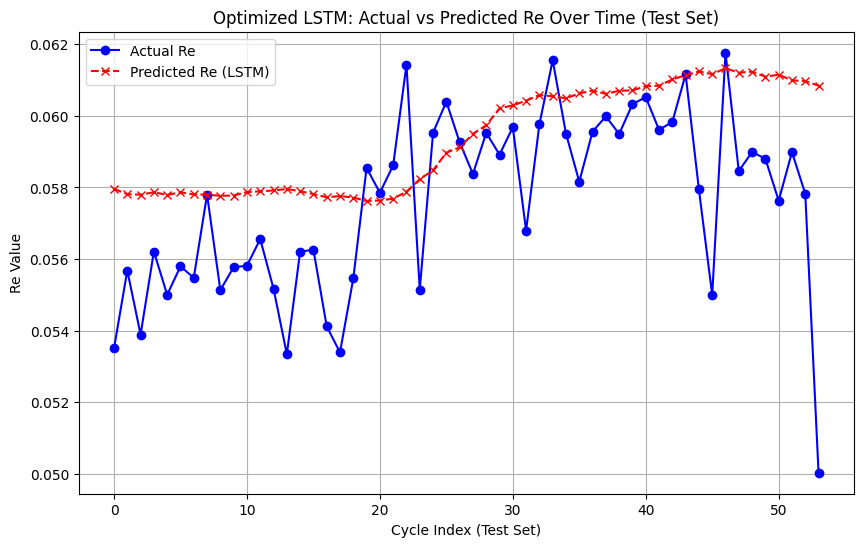

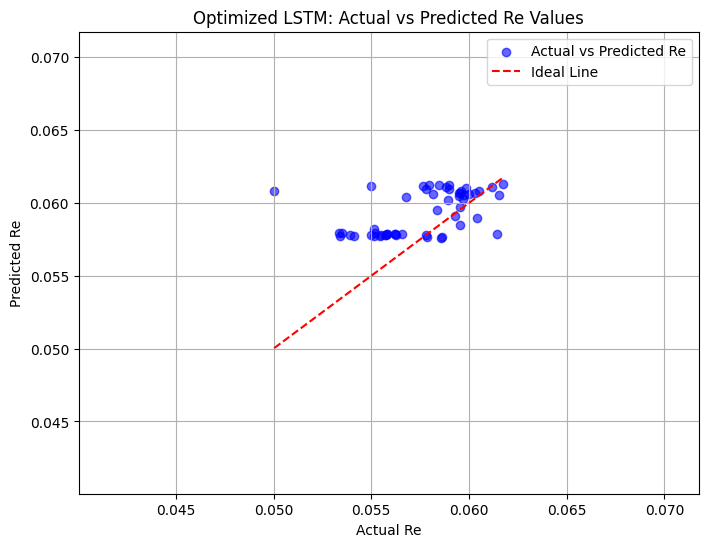

In [35]:
# Plot actual vs predicted over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_original)), y_test_original, marker='o', linestyle='-', color='blue', label='Actual Re')
plt.plot(range(len(y_test_original)), y_pred, marker='x', linestyle='--', color='red', label='Predicted Re (LSTM)')
plt.xlabel('Cycle Index (Test Set)')
plt.ylabel('Re Value')
plt.title('Optimized LSTM: Actual vs Predicted Re Over Time (Test Set)')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot: Actual vs Predicted Re
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred, color='blue', alpha=0.6, label='Actual vs Predicted Re')
min_val = min(np.min(y_test_original), np.min(y_pred))
max_val = max(np.max(y_test_original), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Re')
plt.ylabel('Predicted Re')
plt.title('Optimized LSTM: Actual vs Predicted Re Values')
plt.legend()
plt.grid(True)
plt.xlim(min_val - 0.01, max_val + 0.01)
plt.ylim(min_val - 0.01, max_val + 0.01)
plt.show()